In [10]:
%matplotlib notebook
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
from tqdm import tqdm
import pickle
from collections import OrderedDict
import os
from scipy.ndimage.interpolation import shift
from scipy.optimize import curve_fit
from scipy.stats import linregress
from functools import reduce
import time

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

In [11]:
title = 'early'
dropout_indices = [0]
t_idxs = [i for i in range(13)]

norm_avg_input_per_cell = [1.0, 0.35]
for t_idx in t_idxs[2:]:
    norm_avg_input_per_cell.append(1 + 0.1 * t_idx - 0.2)
    
norm_avg_input_per_cell = [str(x)[:3] for x in norm_avg_input_per_cell]

print(norm_avg_input_per_cell)

dropouts = [0.5]
n_idxs = []

def data_load(path_to_data):
    df = pd.DataFrame({'dropout': [], 'prop': [], 'success': []})
    all_dirs = all_in_dir(path_to_data)
    for direc in all_dirs:
        n_idx = direc[-4:]
        n_idxs.append(n_idx)
        curr_dir = os.path.join(path_to_data, direc)
        for d_idx in dropout_indices:
            for t_idx in t_idxs:
                for f_name in all_files_with_name_frags(curr_dir, [title, 'dropout', str(d_idx), 'tidx', zero_pad(t_idx, 2)]):
                    path_to_file = os.path.join(curr_dir, f_name)
                    loaded = sio.loadmat(path_to_file)
                    prop = loaded['prop'][0][0]
                    success = loaded['success'][0][0]
                    first_spk_times = loaded['first_spk_times'][0]
                    df = df.append({
                        'n_idx': int(n_idx),
                        'dropout': dropouts[d_idx],
                        'prop': prop,
                        'success': success,
                        't_idx': t_idx,
                        'first_spk_times': first_spk_times,
                    }, ignore_index=True)
    return df

['1.0', '0.3', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.0']


In [12]:
df = data_load('./robustness')
df

,dropout,prop,success,first_spk_times,n_idx,t_idx
0,0.5,10000.408869,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5675.0,0.0
1,0.5,6249.202869,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5675.0,1.0
2,0.5,10214.712943,0.0,"[-1.1102230246251565e-16, -1.1102230246251565e...",5675.0,2.0
3,0.5,11388.005326,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5675.0,3.0
4,0.5,12485.110078,0.0,"[-2.220446049250313e-16, -2.220446049250313e-1...",5675.0,4.0
...,...,...,...,...,...,...
203,0.5,32472.759182,0.0,"[-8.881784197001252e-16, -8.881784197001252e-1...",7103.0,8.0
204,0.5,35047.283252,0.0,"[-4.440892098500626e-16, -4.440892098500626e-1...",7103.0,9.0
205,0.5,37783.959325,0.0,"[-8.881784197001252e-16, -8.881784197001252e-1...",7103.0,10.0
206,0.5,44962.406008,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7103.0,11.0


<IPython.core.display.Javascript object>


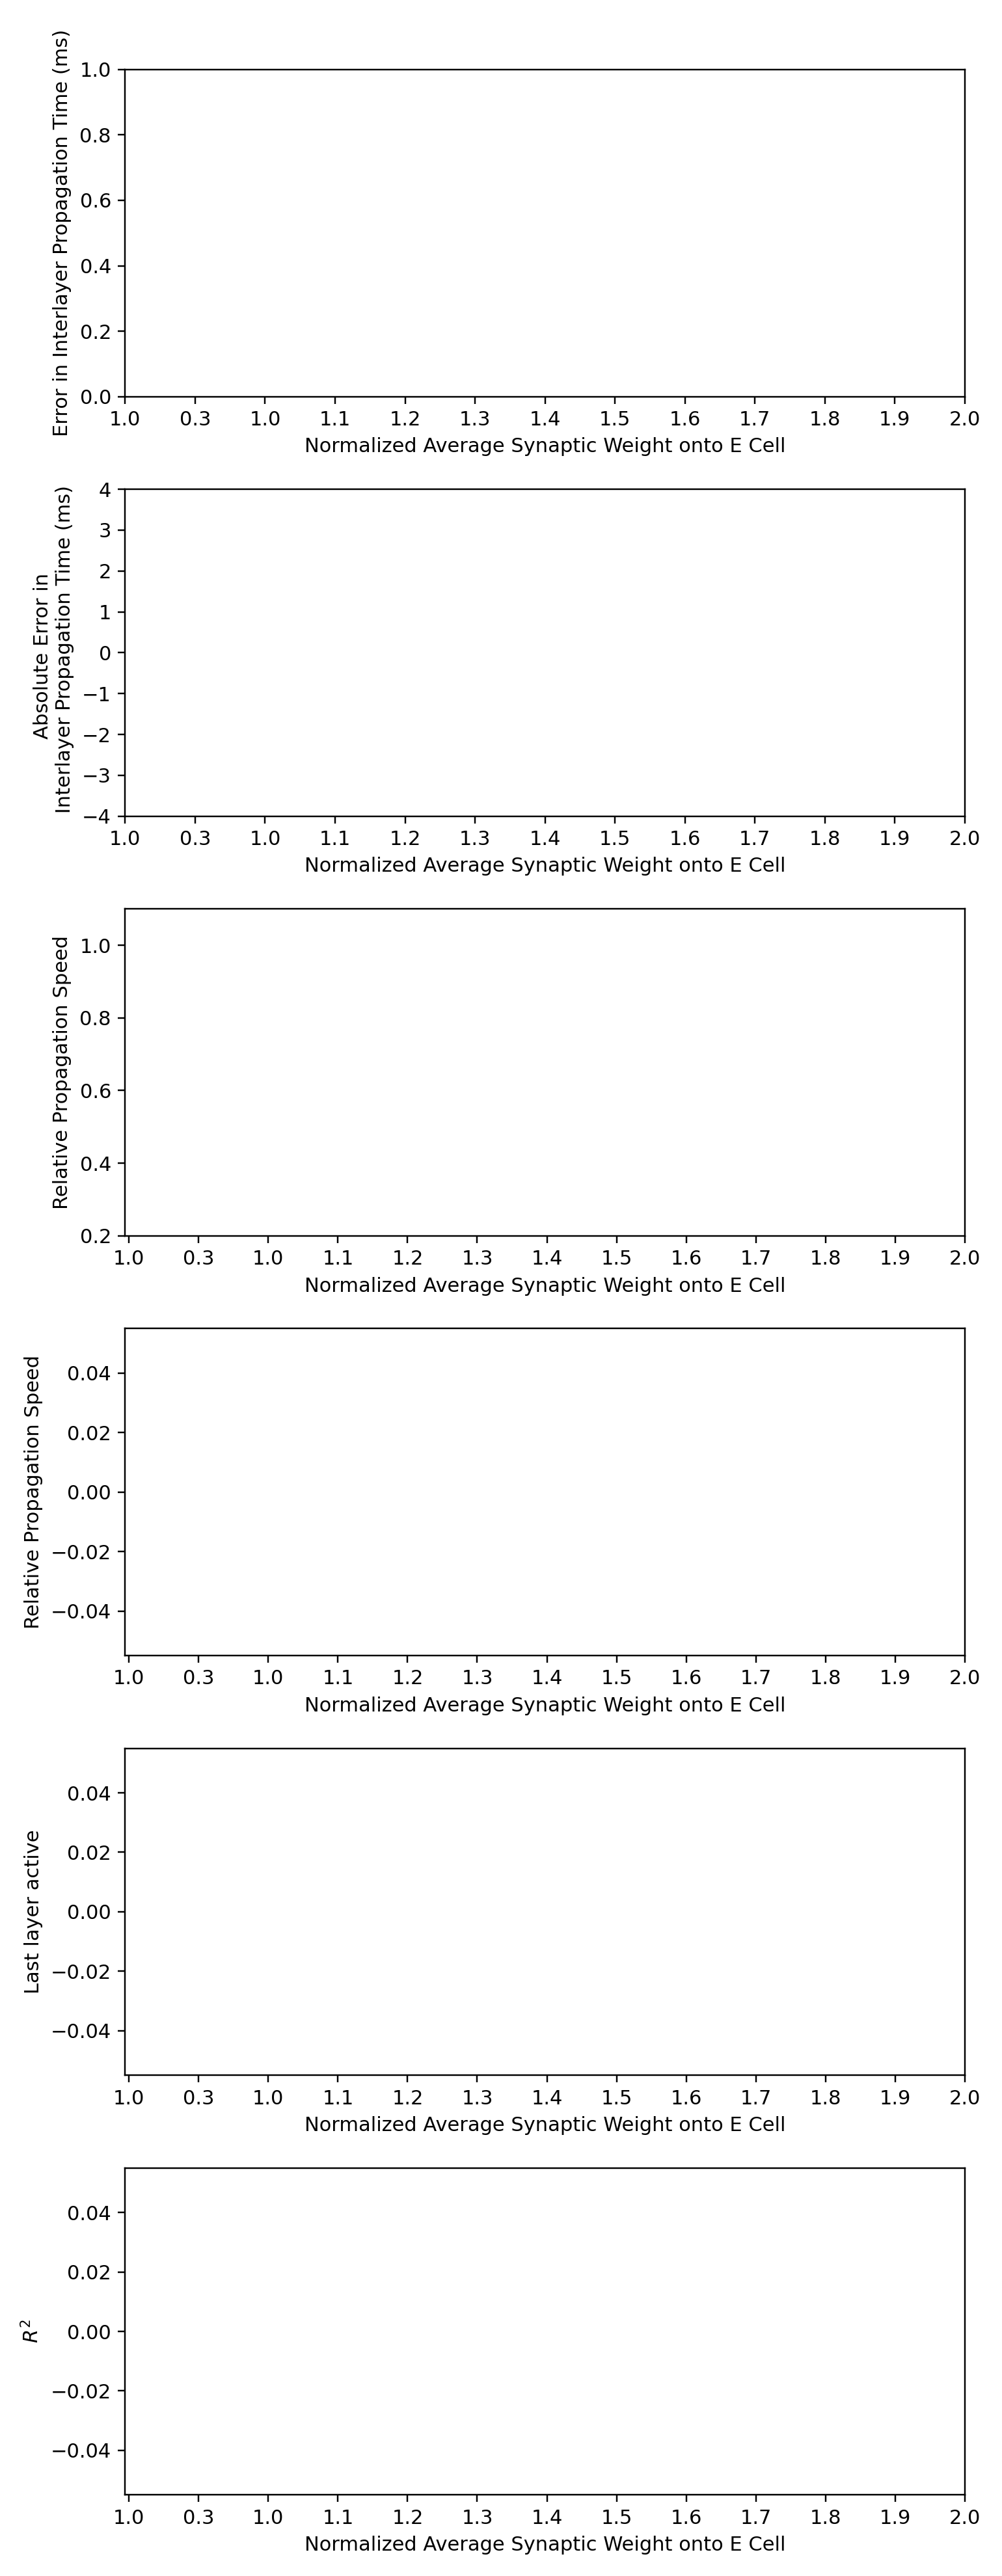

16
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [13]:
fig, ax = plt.subplots(6, 1, figsize=(7, 18), tight_layout=True)

print(len(n_idxs))

print(t_idxs)

for t_idx in t_idxs:
    mean_time_diffs_for_t_idx = []
    rel_props = []
    last_layer_active = []
    goodness_of_fits = []

    for n_idx in n_idxs:
        ctrl_data = select(df, {'n_idx': int(n_idx), 't_idx': 0})
        data_for_t_idx = select(df, {'n_idx': int(n_idx), 't_idx': t_idx})
        
        try:
            first_spk_times_ctrl = ctrl_data['first_spk_times'].iloc[0] * 1000
            first_spk_times_t_idx = data_for_t_idx['first_spk_times'].iloc[0] * 1000
        except IndexError as e:
            continue
        
        cutoff = 0.9
        if np.sum(~np.isnan(first_spk_times_ctrl)) < cutoff * len(first_spk_times_ctrl):
            continue
    
        layer_spk_times_ctrl = []
        layer_spk_times_t_idx = []

        layer_size = 20
        for i in range(0, len(first_spk_times_ctrl), layer_size):
            layer_mean_spk_time_ctrl = np.nanmean(first_spk_times_ctrl[i : i + layer_size])
            layer_mean_spk_time_t_idx = np.nanmean(first_spk_times_t_idx[i : i + layer_size])
            layer_spk_times_ctrl.append(layer_mean_spk_time_ctrl)
            layer_spk_times_t_idx.append(layer_mean_spk_time_t_idx)
            
        for i in range(len(layer_spk_times_t_idx)):
            if np.isnan(layer_spk_times_t_idx[i]):
                last_layer_active.append(i)
                break
        if i == 0:
            continue
        if i == len(layer_spk_times_t_idx) - 1:
            last_layer_active.append(i+1)
        else:
            continue

        def line(x, A):
            return A * x

        layer_spk_times_ctrl = np.array(layer_spk_times_ctrl)
        layer_spk_times_ctrl_trimmed = layer_spk_times_ctrl[~np.isnan(layer_spk_times_ctrl)]
        layer_nums_ctrl_trimmed = np.arange(len(layer_spk_times_ctrl))[~np.isnan(layer_spk_times_ctrl)]

        layer_spk_times_t_idx = np.array(layer_spk_times_t_idx)
        layer_spk_times_t_idx_trimmed = layer_spk_times_t_idx[~np.isnan(layer_spk_times_t_idx)]
        layer_nums_t_idx_trimmed = np.arange(len(layer_spk_times_t_idx))[~np.isnan(layer_spk_times_t_idx)]

        popt1, pcov1 = curve_fit(line, layer_spk_times_t_idx_trimmed, layer_nums_t_idx_trimmed)
        t_idx_slope = popt1[0]

        popt2, pcov2 = curve_fit(line, layer_spk_times_ctrl_trimmed, layer_nums_ctrl_trimmed)
        ctrl_slope = popt2[0]

        inter_layer_time_diffs_ctrl = np.array(layer_spk_times_ctrl[1:]) - np.array(layer_spk_times_ctrl[:-1])
        inter_layer_time_diffs_t_idx = np.array(layer_spk_times_t_idx[1:]) - np.array(layer_spk_times_t_idx[:-1])

        time_diffs = inter_layer_time_diffs_ctrl - inter_layer_time_diffs_t_idx

        mean_time_diffs_for_t_idx.append(time_diffs)

        rel_props.append(t_idx_slope / ctrl_slope)
        
        goodness_of_fits.append(linregress(layer_spk_times_t_idx_trimmed, layer_nums_t_idx_trimmed)[2])
    
    if len(mean_time_diffs_for_t_idx) > 0:
        all_time_diffs = np.concatenate(mean_time_diffs_for_t_idx)
        ax[0].scatter(t_idx + np.random.normal(size=len(all_time_diffs), scale=0.1), all_time_diffs, c='black', s=1)
    
        ax[1].errorbar(t_idx, np.nanmean(np.abs(all_time_diffs)), yerr=np.nanstd(np.abs(all_time_diffs)), c='black')
        ax[1].scatter(t_idx, np.nanmean(np.abs(all_time_diffs)), c='black', s=6)
    
    ax[2].scatter(t_idx + np.random.normal(size=len(rel_props), scale=0.05), rel_props, c='black', s=6)
    ax[5].scatter(t_idx + np.random.normal(size=len(goodness_of_fits), scale=0.05), np.square(goodness_of_fits), c='black', s=6)
    
    ax[3].errorbar(t_idx, np.nanmean(rel_props), yerr=np.nanstd(rel_props), c='black')
    ax[3].scatter(t_idx, np.nanmean(rel_props), c='black', s=6)
    
#     ax[4].errorbar(t_idx, np.nanmean(last_layer_active), yerr=np.nanstd(last_layer_active), c='black')
#     ax[4].scatter(t_idx, np.nanmean(last_layer_active), c='black', s=6)
    
    ax[4].scatter([t_idx] * len(last_layer_active), last_layer_active, c='black', s=6)

#ax[0].set_ylim(-20, 20)
ax[1].set_ylim(-4, 4)

ax[0].set_ylabel('Error in Interlayer Propagation Time (ms)')
ax[1].set_ylabel('Absolute Error in \n Interlayer Propagation Time (ms)')

ax[2].set_ylabel('Relative Propagation Speed')
ax[2].set_ylim(0.2, 1.1)

ax[3].set_ylabel('Relative Propagation Speed')

ax[4].set_ylabel('Last layer active')

ax[5].set_ylabel(r'$R^2$')
    
for a in ax:
    a.set_xticks(t_idxs)
    a.set_xticklabels(norm_avg_input_per_cell)
    a.set_xlabel('Normalized Average Synaptic Weight onto E Cell')